In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from mlm_training.model import Model, make_model_param
from mlm_training.pianoroll import Pianoroll

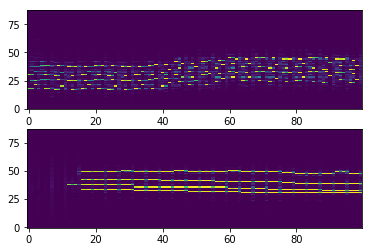

In [106]:
fig, [ax1,ax2] = plt.subplots(2,1)
ax1.imshow(preds_1[2],aspect='auto',origin='lower')
ax2.imshow(preds_1[0],aspect='auto',origin='lower')
plt.show()

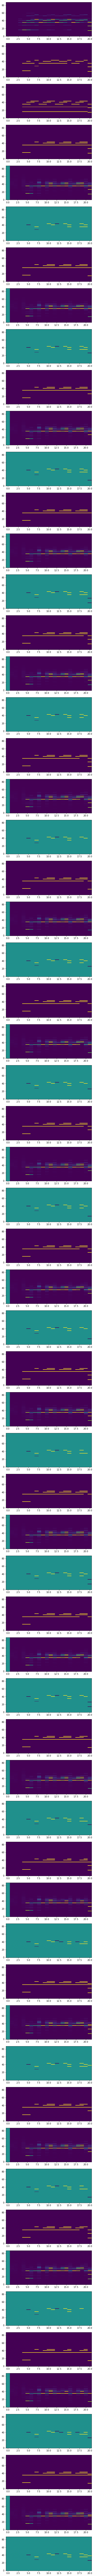

In [37]:
# For viewing beam at a given frame (after running decode.py with --out outputs)

import dataMaps
import pickle

data = dataMaps.DataMaps()
data.make_from_file("data/outputs/valid/MAPS_MUS-mond_1_SptkBGAm.mid", "quant", section=[0, 30])

frame = 20
num = 20

frame = min(data.input.shape[1] - 1, frame)

if num > 0:
    with open("outputs/data_" + str(frame) + ".pkl", "rb") as file:
        out = pickle.load(file)

acoustic = data.input[:, :frame + 1]
midi = data.target[:, :frame + 1]

fig, ax = plt.subplots(3 + num * 3, 1, figsize=(int(15/frame * 10),15 + num * 10))
ax[1].imshow((acoustic>0.5).astype(int), aspect='auto', origin='lower')
ax[0].imshow(acoustic, aspect='auto', origin='lower')
ax[2].imshow(midi, aspect='auto', origin='lower')
for i in range(num):
    ax[3 + 3*i].imshow(out[i][0], aspect='auto', origin='lower')
    ax[4 + 3*i].imshow(out[i][1], aspect='auto', origin='lower')
    ax[5 + 3* i].imshow(out[i][0] - (acoustic>0.5).astype(int), aspect='auto', origin='lower')
plt.show()

In [8]:
import pickle

with open("save/baseline-quant/results.p", "rb") as input_file:
    base = pickle.load(input_file)
    
with open("save/results.p", "rb") as input_file:
    model = pickle.load(input_file)

F_n_diffs = []
for key in base.keys():
    print(key)
    diff = np.array(model[key]) - np.array(base[key])
    F_n_diffs.append(diff[1][2])
    print(diff)
    
print(sorted(F_n_diffs))

MAPS_MUS-alb_se2_ENSTDkCl.mid
[[ 0.00801745 -0.03310345 -0.01638257]
 [ 0.18154762 -0.09917355  0.05833346]]
MAPS_MUS-bk_xmas1_ENSTDkAm.mid
[[ 0.06318788 -0.12024879 -0.07399612]
 [ 0.10911311 -0.21546961 -0.15371382]]
MAPS_MUS-bk_xmas1_ENSTDkCl.mid
[[ 0.05843323 -0.13457557 -0.08599922]
 [ 0.11038961 -0.23756906 -0.16100066]]
MAPS_MUS-bk_xmas4_ENSTDkCl.mid
[[ 0.003139   -0.03406224 -0.01683437]
 [ 0.12102991 -0.12903226  0.00079603]]
MAPS_MUS-bk_xmas5_ENSTDkCl.mid
[[ 0.03831377  0.00529316  0.02219572]
 [ 0.17331663 -0.09243697  0.04793845]]
MAPS_MUS-bor_ps6_ENSTDkCl.mid
[[ 0.01456747 -0.07225994 -0.03426947]
 [ 0.2027027  -0.19018405 -0.07687194]]
MAPS_MUS-chpn_op25_e3_ENSTDkAm.mid
[[-0.05432274 -0.15231458 -0.12578053]
 [ 0.04226682 -0.22380107 -0.18920422]]
MAPS_MUS-chpn_op25_e4_ENSTDkAm.mid
[[ 0.00587287 -0.1604426  -0.09529951]
 [ 0.07493677 -0.22753346 -0.15428335]]
MAPS_MUS-chpn_op33_2_ENSTDkAm.mid
[[ 0.03241279 -0.04311961 -0.01520038]
 [ 0.22908062 -0.05590062  0.05906943]]
M

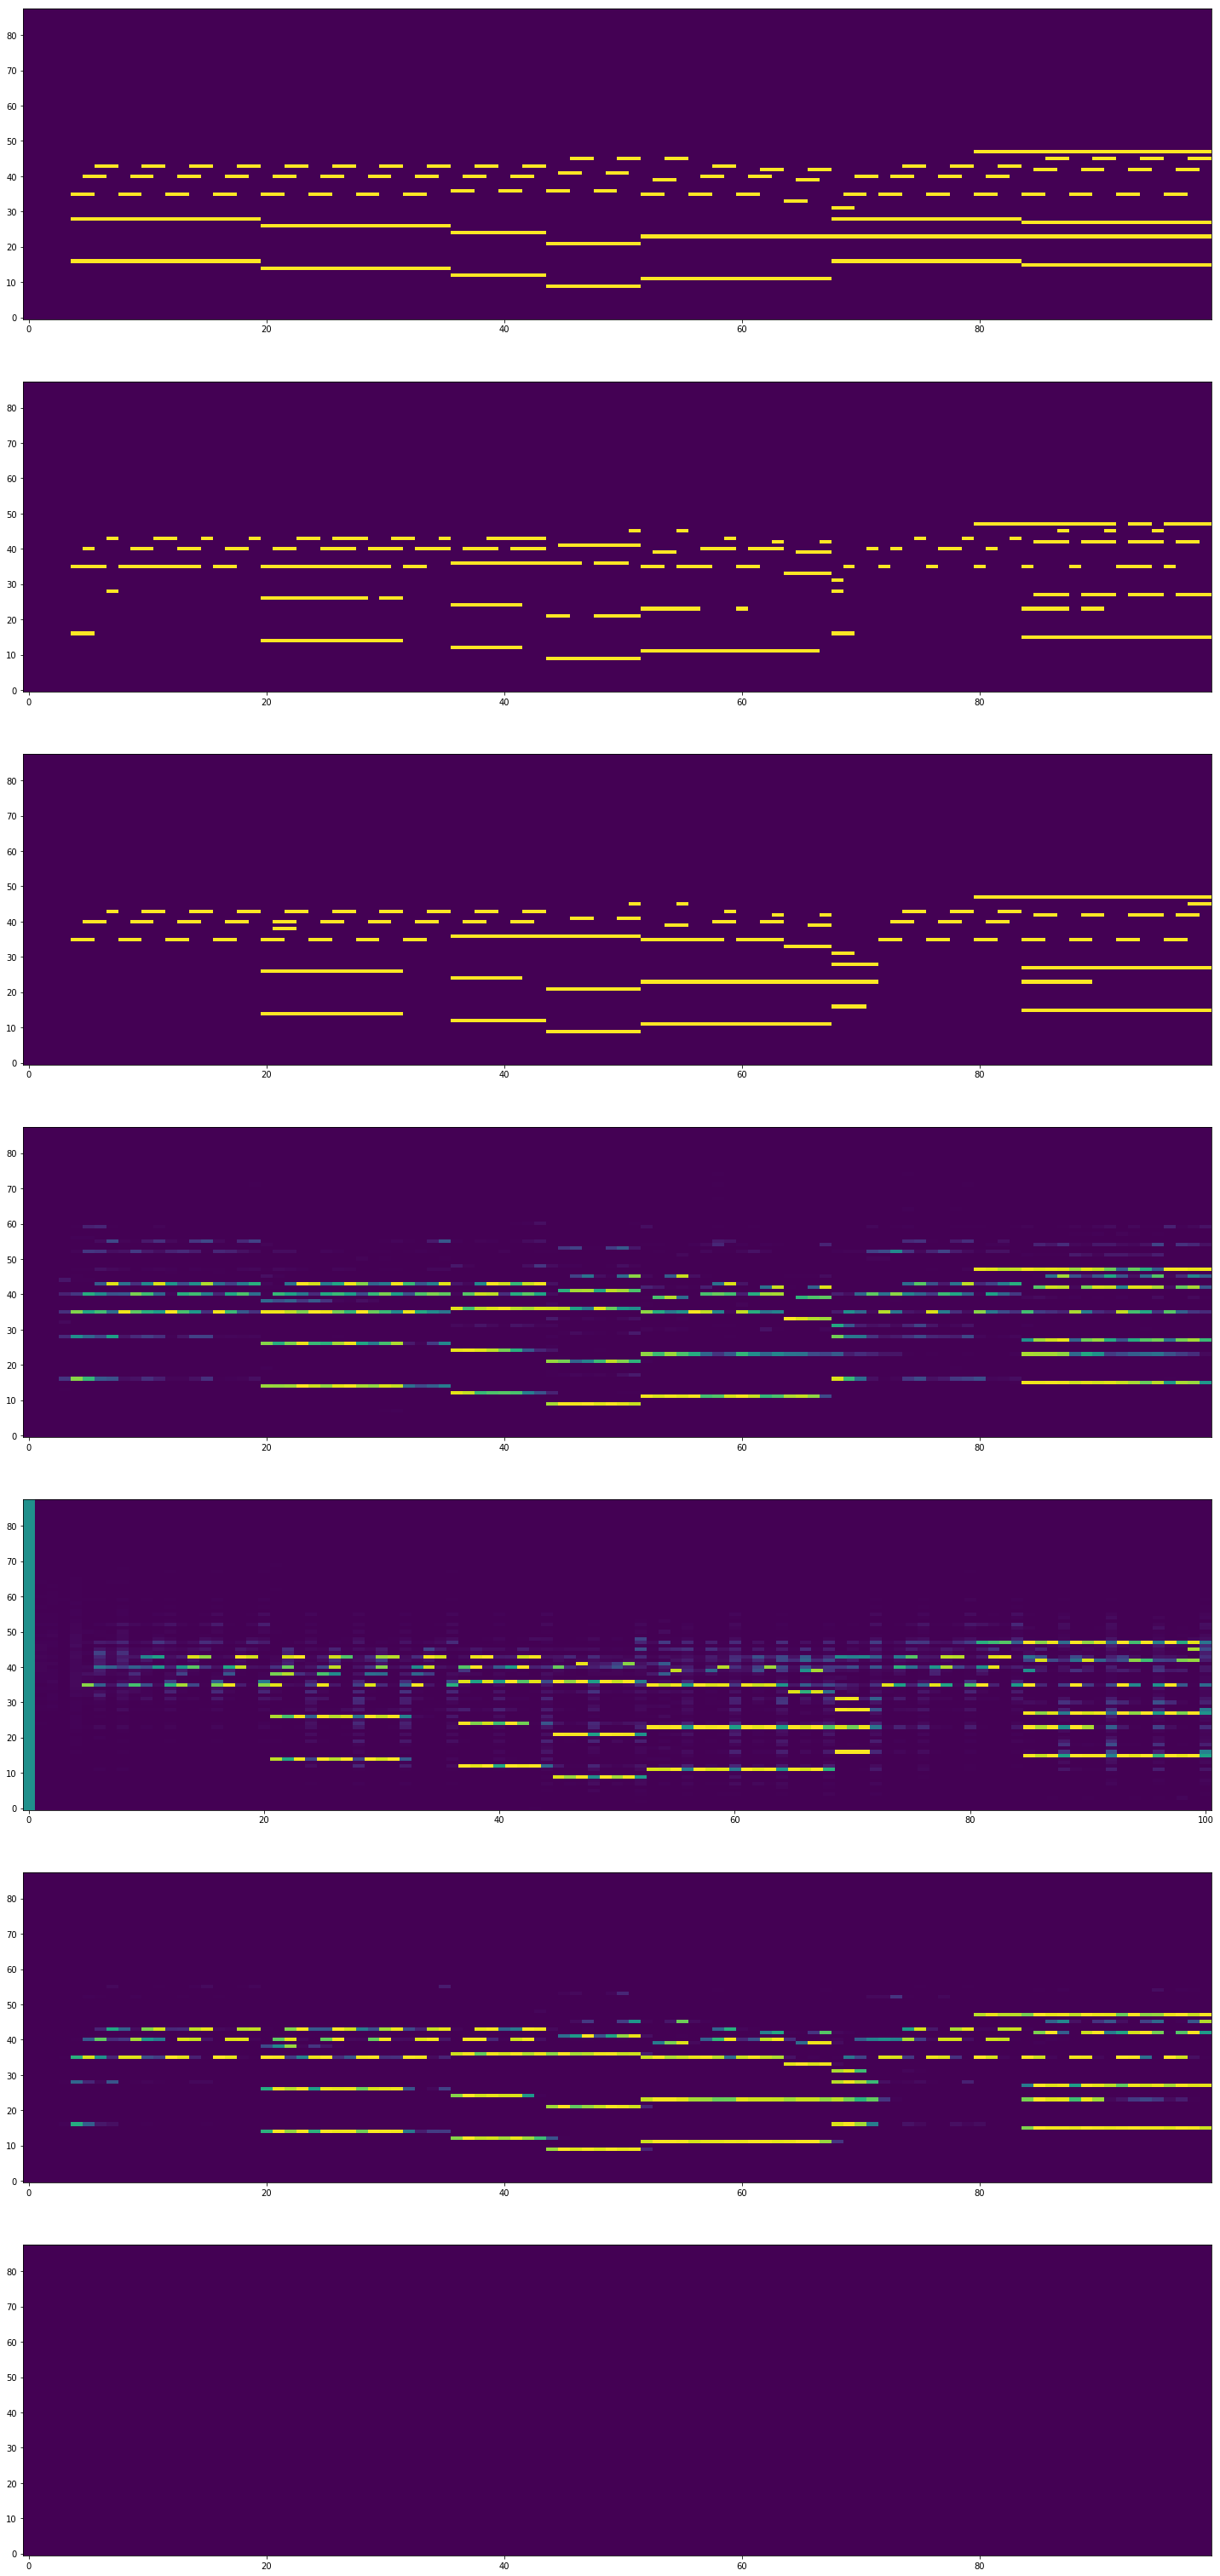

In [2]:
# For viewing results of final output

import dataMaps
import pickle
import numpy as np
import matplotlib.pyplot as plt

pr = np.load("pr.npy")
priors = np.load("priors.npy")
weights = np.load("weights.npy")
combined_priors = np.load("combined_priors.npy")

data = dataMaps.DataMaps()
data.make_from_file("data/outputs/valid/MAPS_MUS-mond_1_SptkBGAm.mid", "quant", section=[0, 30])

acoustic = data.input
midi = data.target

fig, ax = plt.subplots(7, 1, figsize=(25,55))
ax[0].imshow(midi, aspect='auto', origin='lower')
ax[1].imshow((acoustic>0.5).astype(int), aspect='auto', origin='lower')
ax[2].imshow(pr, aspect='auto', origin='lower')
ax[3].imshow(acoustic, aspect='auto', origin='lower')
ax[4].imshow(priors, aspect='auto', origin='lower')
ax[5].imshow(combined_priors, aspect='auto', origin='lower')
ax[6].imshow(weights, aspect='auto', origin='lower')
plt.show()

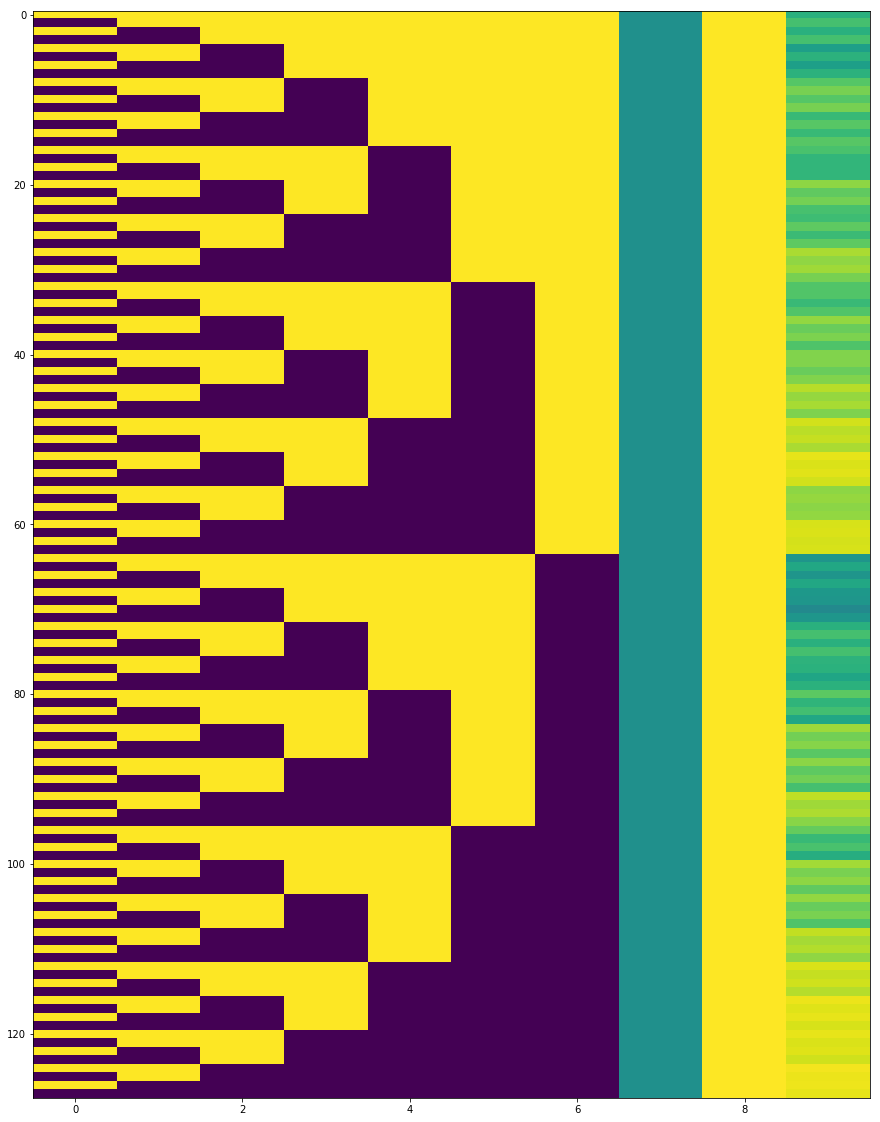

In [122]:
# For investigating weight model

import matplotlib.pyplot as plt
import itertools
import pickle
import sklearn

with open("weight_model.b10_md0.48_h7_l2_prior.quant.best.pkl", "rb") as file:
    model = pickle.load(file)["model"]

ac = 0.5
la = 1.0

lst = np.array([list(i) for i in itertools.product([0, 1], repeat=7)])[::-1,::-1]

data = np.zeros((len(lst), 10))
data[:, :7] = lst
data[:, 7] = ac
data[:, 8] = la

data[:, 9] = model.predict_proba(data[:, :9])[:, 1]

#data = data[np.where(data[:, 6] == 1)[0]]

fig, ax = plt.subplots(figsize=(15, 20))
ax.imshow(data, aspect='auto')
plt.show()